# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


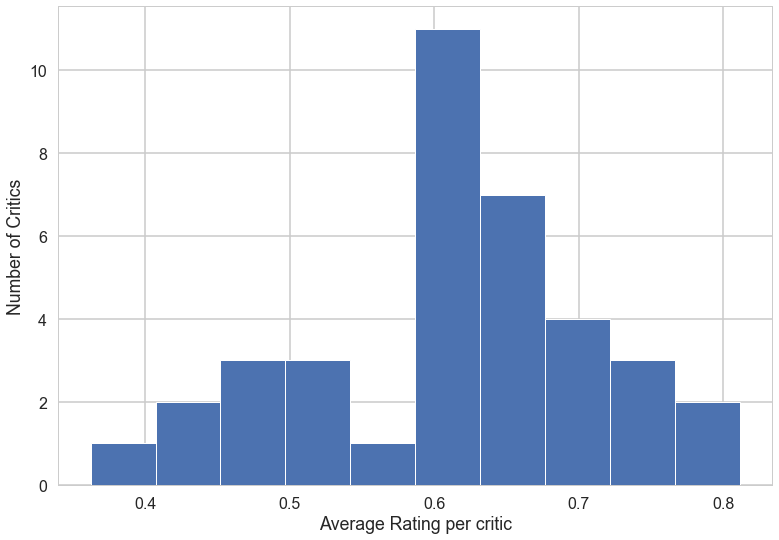

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?


**Response:** The majority of critics give more than 60% of movies a positive review. Few critics give more than 80% of positive reviews, and few give less than 30% of positive reviews. 

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?


In [7]:
#your turn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

xtrain, xtest, ytrain, ytest = train_test_split(X,y)
clf = MultinomialNB().fit(xtrain, ytrain)
train_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)
print('Multinomial Naive Bayes')
print('Accuracy on the test set: {}'.format(test_accuracy))
print('Accuracy on the training set: {}'.format(train_accuracy))

Multinomial Naive Bayes
Accuracy on the test set: 0.7807761500899512
Accuracy on the training set: 0.9197943444730077


**Response:** The accuracy score on the test set is only about 77%, while the score on the training set is more than 92%. This suggests that the multinominal Naive Bayes classifier overfits the training data, so the classifer does not perform well in predicting the unseen data. 

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents **the minimum number of documents a word must appear in** for it to be included in the vocabulary. If it is a float, it represents **the minimum *percentage* of documents a word must appear in** to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>


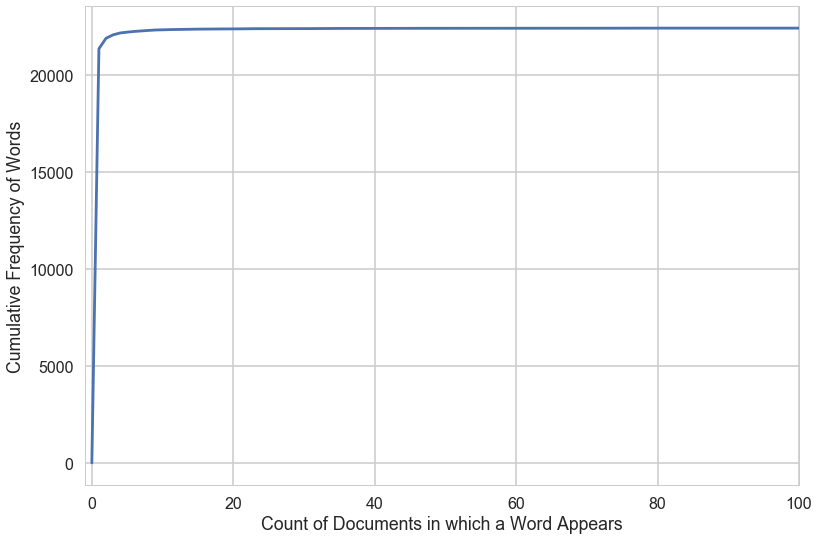

In [8]:
# For each word, count the number of documents that contains it 
count = (X>0).sum(axis=0).tolist()[0]
count = sorted(count)
n = np.unique(count)

# Compute the frequency of words that appear in exactly k documents
freq, cat = np.histogram(count, bins = len(n))
cumfreq = np.cumsum(freq)
cumfreq = np.insert(cumfreq,0,0)
n = np.insert(n,0,0)

plt.plot(n,cumfreq)
plt.xlim(-1,100)
plt.xlabel('Count of Documents in which a Word Appears')
plt.ylabel('Cumulative Frequency of Words')
plt.show()

**Response:** `min_df` is used to removed terms that are too rare, and `max_df` is used to remove terms that are too common. Out of a total of 22417 words, 95% of them appear in only one document but they are also very rare words. Only a few words are extremely common, so if `min_df` is one and we choose `max_df` to be around 20, we will cover more than 99% of the vocabulary. 

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [9]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [10]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x) # returns an array of shape = [n_samples,n_classes]
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [11]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(critics.shape[0]), train_size=0.7,random_state=5)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True  

<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>


**Response:** The `log_likelihood` measures the probability of observing the data given the parameters. To maximize the `log_likelihood` means that we are trying to find the parameters that maximize the probability of predicting the training data. Since $\alpha$ is an additive (Laplace/Lidstone) smoothing parameter, a larger $\alpha$ will reduce the variance of the model (and overfitting) but increase bias at the same time. We can think of $\alpha$ as a pseudocount of the number of times a word has been seen. In the following code, I use grid search to find the best $\alpha$ as well as the best `min_df` that will maximize the probability of observing the training data. 

In [12]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [0.1, 1, 5, 10, 50]
min_dfs = [0.00001, 0.0001, 0.001, 0.01, 0.1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # Cross validate the NB model and compute a log likelihoood score
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, scorefunc=log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
    #print(alpha, best_min_df, maxscore)

In [13]:
print("Best alpha: {}\nBest min_df: {}".format(best_alpha, best_min_df))

Best alpha: 5
Best min_df: 0.001


<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>



In [14]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.801028
Accuracy on test data:     0.717407


**Response:** Now with the best tuning parameters, we reduce the problem of overfitting, as the accuracy on the training data falls from 92% to 80%. The accuracy on the test set is also lower, but the model is probably more robust in predicting unseen data. 

In [15]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2075 2174]
 [ 904 5739]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [16]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1]) # create an identity matrix with the number of features
probs = clf.predict_log_proba(x)[:, 0] # the model's probabilities of prediciting rotten reviews
ind = np.argsort(probs) # return the indices based on sorting the predicted probabilities

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             perfect 0.86
            touching 0.86
         masterpiece 0.85
        entertaining 0.85
                rare 0.84
               great 0.83
           enjoyable 0.83
             delight 0.82
           excellent 0.82
           beautiful 0.82
Bad words	     P(fresh | word)
           obviously 0.30
          uninspired 0.30
             problem 0.30
           pointless 0.28
              forced 0.28
               wants 0.28
               video 0.28
               worst 0.28
                dull 0.22
       unfortunately 0.22


<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>



**Response:** By creating an identity matrix with the size of the number of features/words, each row represents exactly one feature/word. We then use this one word to predict the probabilitiy of freshness or rottenness of a review that contains this word. If one single word can generate high probability of a review being fresh or rotten, that implies this feature has a high predictive power. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [17]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0] # Generate the probabilities of predicting a rotten review
predict = clf.predict(x) 

# indices of reviews that are predicted most fresh but are actually rotten
bad_rotten = np.argsort(prob[y == 0])[:5] 
# indices of reviews that are predicted most rotten but are actually fresh
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
With its feints at horror and pathos, the third Star Wars film is the most Disney-esque in its emotional outline, yet that outline is buried beneath an obnoxiously hyped-up pace that reduces the emotions to rubble.

With animated movies coming out every other week or so, mediocrity is becoming a rule. Open Season loses more points than most films because of its similarities to Over the Hedge, one of the few kids films that did it right this year.

Directed with composure, but no great fervour, the film's conspicuously uninterested in American football, and much concerned with testing the limits and the resilience of the American dream.

This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.

It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie tha

<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>


In [18]:
#your turn
text = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
clf.predict_proba(text)

array([[ 0.04270181,  0.95729819]])

**Response:** Our best trained classifier predicts that this new one-sentence review is fresh with a probability of 96%, but it is clearly a negative review that is misclassified. The bag-of-words approah does not take into account the word 'not' which negates the positive description that follows. One way to solve this problem is to use bigrams, which will read in the phrase 'not remarkable' and generate a better prediction. Anothe way is to use random forest, which will allow for interactions between words. 

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$.

See links:
(1) http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
(2) http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref

<h3>Exercise Set VIII: Improving the Model</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.


**1. Naive Bayes Model Where Features are N-grams**

In [19]:
# Specify the grid of parameters to search over
alphas = [0.1, 1, 5, 10]
min_dfs = [0, 0.00001, 0.0001, 0.001, 0.01]

# Find the best value for alpha and min_df, and the best NB classifier with bigrams
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(ngram_range=(1,2), min_df=min_df, max_df=0.1)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
        # Cross validate the NB models and compute a log likelihoood score for each model
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, scorefunc=log_likelihood)
        if score > maxscore:
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
    #print(alpha, best_min_df, maxscore)

In [20]:
print('Best alpha: {}\nBest min_df: {}'.format(best_alpha,best_min_df))

Best alpha: 5
Best min_df: 0.001


In [21]:
## Use both unigrams and bigrams instead of only unigrams.
ngram_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=best_min_df, max_df=0.1)
X, y = make_xy(critics, ngram_vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.827586
Accuracy on test data:     0.727231


In [22]:
words = np.array(ngram_vectorizer.get_feature_names())

x = np.eye(xtest.shape[1]) # create an identity matrix with the number of features
probs = clf.predict_log_proba(x)[:, 0] # the model's probabilities of prediciting rotten reviews
ind = np.argsort(probs) # return the indices based on sorting the predicted probabilities

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             perfect 0.87
            touching 0.86
         masterpiece 0.86
        entertaining 0.86
            the best 0.85
                rare 0.85
               great 0.84
           enjoyable 0.83
             delight 0.83
              not be 0.83
Bad words	     P(fresh | word)
             problem 0.31
              forced 0.30
           pointless 0.30
               wants 0.29
               video 0.29
               worst 0.29
          doesn have 0.27
              is too 0.24
                dull 0.23
       unfortunately 0.23


In [23]:
# Check how well the model predicts the freshness of this sentence that was misclassified
text = ngram_vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
clf.predict_proba(text)

array([[ 0.05617296,  0.94382704]])

**Result 1:** Now the Naive Bayes classifier that uses both single words and bigrams can sometimes increase its predictive probability that this one-sentence review is rotten. But this is not always true. If we use trigrams or more, the feature set will become too sparse to improve performance. 

**2. Random Forest Model** 

In [24]:
from sklearn.ensemble import RandomForestClassifier

ns = [10, 40, 60, 90]
min_dfs = [0.00001, 0.0001, 0.001, 0.01]
best_n = None
best_min_df = None
maxscore=-np.inf

for n in ns: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        X, y = make_xy(critics, vectorizer)
        Xtrain = X[mask]
        ytrain = y[mask]
        
        clf = RandomForestClassifier(n_estimators=n, random_state=5)
        result = 0
        for train, test in KFold(5).split(Xtrain):
            clf.fit(Xtrain[train],ytrain[train])
            result += clf.score(Xtrain[test],ytrain[test])
            score = result / 5
        if score > maxscore:
            maxscore = score
            best_min_df = min_df
            best_n = n
    #print(n, best_min_df, maxscore)
print('Best number of trees: {}\nBest min_df: {}'.format(best_n,best_min_df))

Best number of trees: 90
Best min_df: 0.001


In [25]:
vectorizer = CountVectorizer(min_df=best_min_df)       
X, y = make_xy(critics, vectorizer)
Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = RandomForestClassifier(n_estimators=best_n, random_state=5).fit(Xtrain, ytrain)
training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.998072
Accuracy on test data:     0.686559


In [26]:
text = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
clf.predict_proba(text)

array([[ 0.16666667,  0.83333333]])

**Result 2:** The best Random Forest classifier builds 90 decision trees and is trained with features/words that appear in at least 0.1% of all reivews. The training accuracy is close to 100%, but the testing accuracy is only about 69%. Even the best Random Forest classifier still misclassifies a review describing a 'not remarkable' movie as fresh.

**3. Latent Dirichlet Allocation (LDA)**

Latent Dirichlet Allocation is a generative model for topic discovery. The model assumes that each document belongs to a small number of topics and that each word is attributable to one of the document's topics. 

In [27]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim

In [28]:
vectorizer = CountVectorizer(min_df=1, max_df=0.1, stop_words='english')
X = vectorizer.fit_transform(critics.quote)

In [29]:
corpus=vectorizer.get_feature_names()
id2words = dict((v, k) for k,v in vectorizer.vocabulary_.items())
corpus_gensim = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [30]:
lda = gensim.models.ldamodel.LdaModel(corpus_gensim, id2word=id2words, num_topics=3, update_every=1, chunksize=1000, passes=1)

In [31]:
lda.print_topics()

[(0,
  '0.006*"good" + 0.005*"best" + 0.005*"like" + 0.004*"thriller" + 0.004*"comedy" + 0.004*"story" + 0.004*"time" + 0.004*"isn" + 0.003*"great" + 0.003*"just"'),
 (1,
  '0.006*"new" + 0.005*"director" + 0.005*"comedy" + 0.004*"work" + 0.004*"like" + 0.003*"doesn" + 0.003*"time" + 0.003*"characters" + 0.003*"does" + 0.003*"life"'),
 (2,
  '0.005*"like" + 0.004*"humor" + 0.004*"story" + 0.003*"little" + 0.003*"character" + 0.003*"screen" + 0.003*"big" + 0.003*"funny" + 0.003*"characters" + 0.003*"performance"')]

**Result 3:** In vectorizing the documents I removed the English stop words as well as many commonly words across all documents (`max_df=0.1`) in order to find specific words that can help us discover topics. With these movie reviews, it seems to be quite difficult to determine the topics. The topics might be related to the genre of the movies or the movies being funny or novel.  

**4. The Skip-Gram and Continuous Bag-of-Words Models**

Word2vec is based on the idea that similar words have similar context. The model includes two algorithms: continuous bag-of-words (CBOW) and skip-gram. Skip-gram aims to predict the probability of context words from a center word, and CBOW predicts a center word from the surrounding context words. The two training methods are negative sampling and hierarchical softmax. 

**5. Term Frequency and Inverse Document Frequency (TF-IDF)**

Counting the term frequency in a document is a rough measure of term importance. But if a frequent term appears in almost every document, it is then not very useful in prediction. So we can multiple this term frequency with the inverse of its popularity in all documents. This will downweight words like "movie" that shows up in all reviews and increase the weight of words that appear only in a few documents.

In [32]:
# Use term importance measured by TF-IDF weighting instead of word counts
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
# Specify the grid of parameters to search over
alphas = [0.1, 1, 5, 10]
min_dfs = [0, 0.00001, 0.0001, 0.001]
max_dfs = [0.05, 0.1, 0.3, 0.5, 0.7]

# Find the best value for alpha and min_df, and the best NB classifier with bigrams
best_alpha = None
best_min_df = None
best_max_df = None
maxscore=-np.inf
for alpha in alphas: 
    for min_df in min_dfs:
        for max_df in max_dfs:
            tfidfvectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words='english')      
            Xthis, ythis = make_xy(critics, tfidfvectorizer)
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]
            clf = MultinomialNB(alpha=alpha)
            score = cv_score(clf, Xtrainthis, ytrainthis, scorefunc=log_likelihood)
            if score > maxscore:
                maxscore = score
                best_alpha = alpha
                best_min_df = min_df
                best_max_df = max_df

In [34]:
print('Best alpha: {}\nBest min_df: {}\nBest max_df: {}'.format(best_alpha,best_min_df,best_max_df))

Best alpha: 0.1
Best min_df: 0
Best max_df: 0.3


In [35]:
tfidfvectorizer = TfidfVectorizer(best_min_df, best_max_df, stop_words='english')
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.974513
Accuracy on test data:     0.723283


In [36]:
text = tfidfvectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
clf.predict_proba(text)

array([[ 0.00623205,  0.99376795]])

In [37]:
words = np.array(tfidfvectorizer.get_feature_names())

x = np.eye(xtest.shape[1]) # create an identity matrix with the number of features
probs = clf.predict_log_proba(x)[:, 0] # the model's probabilities of prediciting rotten reviews
ind = np.argsort(probs) # return the indices based on sorting the predicted probabilities

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.99
            touching 0.99
             delight 0.99
         imaginative 0.98
          surprising 0.98
            funniest 0.98
               witty 0.98
              wilder 0.98
              deftly 0.98
             amazing 0.97
Bad words	     P(fresh | word)
                dull 0.05
        unsatisfying 0.04
     disappointingly 0.04
          uninspired 0.04
             unfunny 0.04
               tepid 0.04
        dramatically 0.04
         forgettable 0.04
              forced 0.04
           pointless 0.03


**Result 4:** Using TF-IDF to vectorize the documents generate similar results as before. 